<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/Segment_Axial_Currents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Detailed=True #Note: The notebook is not yet tuned for Reduced-order segments.

In [ ]:
github=False # Change for whether or not you want to get the model from github or google drive
#This notebook is not github compatible at the moment

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
from mpl_toolkits import mplot3d
import pdb #python debugger

In [2]:
import shutil
if github==True: # If you do not already have the model, comment the above and uncomment below
  # shutil.rmtree('Stylized-ReducedOrder-L5-Model/') #removes folder if already cloned
  !git clone https://github.com/davidfague/Stylized-ReducedOrder-L5-Model.git
  %cd Stylized-ReducedOrder-L5-Model/
else: #If you have the folder in your google drive (easier to update geom_parameters)
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Stylized-ReducedOrder-L5-Model/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Stylized-ReducedOrder-L5-Model


In [57]:
if Detailed==True:
  output_folder = 'Detailedoutput_control'
  v = h5py.File('./{}/Detailedv_report.h5'.format(output_folder),'r') #read segment voltage traces
  segs = pd.read_csv('Detailedoutput_control/DetailedSegments.csv') # read segment values
else:
  output_folder = 'output_control'
  v = h5py.File('./{}/v_report.h5'.format(output_folder),'r') #read segment voltage traces
  segs = pd.read_csv('Segments.csv') # read segment values

In [4]:
#Usefull subsetting method
# print(segs[(segs.Type=='soma')]) #how to separate by type
somasegIDs = segs[(segs.Type=='soma')]['segmentID'] #how to pull a column after separating by type

In [5]:
segs.head() # visualize columns

,segmentID,BMTK ID,Seg_L,Seg_diam,X,Type,Sec ID,Distance,Section_L,Section_diam,Section_nseg,Section_Ra,Coord X,Coord Y,Coord Z,ParentSegID,Elec_distance
0,0,0,4.633872,9.290377,0.1,soma,0,2.316936,23.169362,17.526643,5,100.0,-9.249733,-0.577674,0.0,NaN,0.998333
1,1,0,4.633872,15.657015,0.3,soma,0,6.950809,23.169362,17.526643,5,100.0,-4.624868,-0.288877,0.0,0.0,0.999377
2,2,0,4.633872,17.526643,0.5,soma,0,11.584681,23.169362,17.526643,5,100.0,-0.000010,0.000021,0.0,1.0,1.000000
3,3,0,4.633872,15.446328,0.7,soma,0,16.218553,23.169362,17.526643,5,100.0,4.624854,0.288824,0.0,2.0,0.999389
4,4,0,4.633872,9.437299,0.9,soma,0,20.852426,23.169362,17.526643,5,100.0,9.249712,0.577722,0.0,3.0,0.998310


In [6]:
#Get Columns
segIDs=segs['segmentID']

# segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index() #not sure what this does
segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'
AllSegXCoord=segs['Coord X']
AllSegYCoord=segs['Coord Y']
AllSegZCoord=segs['Coord Z']
AllSegSec_ID=segs['Sec ID']
AllSegSec_name=segs['Type']
segLs=segs["Seg_L"]
segxs=segs["X"]
segdists=segs["Distance"]
SegSecL=segs["Section_L"]
segdiams=segs["Seg_diam"]
SegSecnseg=segs["Section_nseg"]
secRas=segs["Section_Ra"]
psegIDs=segs["ParentSegID"]
secids=segs["Sec ID"]
bmtkid=segs["BMTK ID"]

seg_v=v['report']['biophysical']['data'][:,0] # get segment 0 voltage trace
print(len(seg_v)) #should be equivalnt to (tstop=1000ms)/(dt=0.1ms)=10000

tstop=1000 #simulation stop
dt=0.1 #timestep
t=np.arange(0,tstop,dt) #time array
print(len(t))
if len(t)!=len(seg_v):
  pdb.set_trace()

psegids=[]
for i in range(len(psegIDs)):
  if np.isnan(psegIDs[i]) == False:
    psegids.append(int(psegIDs[i]))
  else:
    psegids.append(psegIDs[i])

In [7]:
print(psegids)

[nan, 0, 1, 2, 3, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 12, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 44, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 9, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 2, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 137, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 134, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 161, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 156, 218, 219, 220, 221

In [50]:
print(len(segIDs)) # number of segments
print(len(psegids))

2526
2526


In [51]:
#early attempts at indexing
# seginterest=[1685,1686,1900] #choose segments indexes to probe
# colors=['blue','purple','orange'] #specify colorchoose colors

In [11]:
probes=[]
j=0 #index color list
class probe():
  def __init__(self,seg,sectionindex,sectionname,color,XCoord,YCoord,ZCoord,secRa,segdiam,segx,segdist,sectionL,sectionNseg,segL,seg_v,parentseg):
    self.seg=seg
    self.sectionindex=sectionindex
    self.sectionname=sectionname
    self.color=color
    self.XCoord=XCoord
    self.YCoord=YCoord
    self.ZCoord=ZCoord
    self.secRa=secRa
    self.segdiam=segdiam
    self.x=segx
    self.segdist=segdist
    self.secL=sectionL
    self.secnseg=sectionNseg
    self.segL=segL
    self.seg_v=seg_v
    self.name='sec:'+str(self.sectionname)+str(self.sectionindex)+' seg:'+str(self.seg)
    self.adjprobes=[]
    self.parentprobe=[]
    self.childprobes=[]
    self.axialcurrents=[]
    self.parentaxialcurrent=[]
    self.childrenaxialcurrents=[]
    self.halfsegRa=.01*self.secRa*(self.secL/2/self.secnseg)/(np.pi*(self.segdiam/2)**2)
    self.parentseg=parentseg

    # try:
    #   self.axial_current=[Record_Axial_Current(section,single_seg=True)]
    # except:
    #   print(section)
for i in range(len(segIDs)):
  try:
    newprobe=probe(seg=i,sectionindex=AllSegSec_ID[i],sectionname=str(AllSegSec_name[i]),color=colors[j],XCoord=AllSegXCoord[i],YCoord=AllSegYCoord[i],ZCoord=AllSegZCoord[i],
                  secRa=secRas[i],segdiam=segdiams[i],segx=segxs[i],segdist=segdists[i],sectionL=SegSecL[i],sectionNseg=SegSecnseg[i],segL=segLs[i],
                  seg_v=v['report']['biophysical']['data'][:,i],parentseg=psegids[i])
  except: #use red if colors isn't long enough
        newprobe=probe(seg=i,sectionindex=AllSegSec_ID[i],sectionname=str(AllSegSec_name[i]),color='r',XCoord=AllSegXCoord[i],YCoord=AllSegYCoord[i],ZCoord=AllSegZCoord[i],
                secRa=secRas[i],segdiam=segdiams[i],segx=segxs[i],segdist=segdists[i],sectionL=SegSecL[i],sectionNseg=SegSecnseg[i],segL=segLs[i],
                seg_v=v['report']['biophysical']['data'][:,i],parentseg=psegids[i])
  j+=1 #index color list
  probes.append(newprobe)

In [13]:
# psegs=[] #list of segment ids for a section's parentseg(), which is the segment that the section is attached to
# parentsegs=list(set(psegids)) # remove duplicates of the list of segment parentsegmentIDs
# # print(parentsegs)
# for j in range(len(segIDs)):
#   for i in range(len(parentsegs)):
#     if np.isnan(parentsegs[i]) == False: #remove nan
#       psegs.append(int(parentsegs[i])) #convert to integer again
#     # else: #if nan, then this segment is really the first segment
#     psegs.append(int())
# # print('psegs:',psegs)

firstsegs = [] #list of segment indices for each section's first segment
sections=[] #list of already seen section ids

for i in range(len(bmtkid)):
    if bmtkid[i] not in sections: #make sure secid is unique
      sections.append(bmtkid[i]) #add unique secid to list of already seen secids
      firstsegs.append(segIDs[i]) #get a list of first segment by unique section id

print('firstsegs:',firstsegs)

firstsegs: [0, 5, 10, 13, 44, 45, 64, 103, 130, 135, 138, 141, 156, 157, 162, 191, 218, 227, 230, 231, 238, 243, 244, 249, 258, 259, 262, 267, 274, 287, 322, 327, 332, 351, 370, 387, 390, 421, 432, 447, 460, 479, 498, 505, 508, 513, 530, 559, 560, 561, 572, 575, 576, 587, 588, 593, 614, 615, 626, 629, 654, 685, 702, 719, 740, 745, 750, 755, 782, 803, 814, 835, 870, 875, 914, 917, 940, 945, 958, 967, 976, 979, 992, 997, 1024, 1027, 1036, 1049, 1054, 1063, 1064, 1065, 1068, 1073, 1082, 1113, 1130, 1131, 1154, 1185, 1198, 1201, 1204, 1239, 1260, 1293, 1302, 1307, 1314, 1319, 1324, 1331, 1334, 1335, 1338, 1353, 1368, 1371, 1372, 1397, 1410, 1431, 1480, 1535, 1552, 1561, 1602, 1603, 1612, 1617, 1634, 1649, 1654, 1655, 1658, 1683, 1696, 1739, 1762, 1801, 1802, 1803, 1806, 1809, 1812, 1813, 1860, 1895, 1902, 1935, 1956, 1959, 1964, 2003, 2022, 2051, 2060, 2071, 2078, 2091, 2098, 2113, 2140, 2169, 2192, 2207, 2212, 2215, 2222, 2237, 2246, 2263, 2280, 2311, 2312, 2321, 2322, 2325, 2330, 2351, 2

Below code is being adjusted to only probe parentsegments, and 

In [14]:
#getting adjacent probes using parent segmemt IDs
for i in range(len(psegids)): #iterate through segment index
  if np.isnan(psegids[i]) == False:
    for seg in segIDs: #check segIDs
      if psegids[i]==seg: #find parent seg from parent seg id
        probes[seg].adjprobes.append(probes[i]) #add child probe to probe's adjprobe list
        probes[seg].childprobes.append(probes[i]) #add child probe to probe's childprobe list

In [15]:
for i in range(len(segIDs)):
  if np.isnan(psegids[i]) == False:
    probes[i].adjprobes.append(probes[int(psegids[i])]) #add parent seg probe to adj probes
    probes[i].parentprobe.append(probes[int(psegids[i])]) #add parent seg probe to parent probes

In [16]:
#compute axial currents between probes
for probe in probes:
  for adjprobe in probe.adjprobes:
    axc=(probe.seg_v-adjprobe.seg_v)/(probe.halfsegRa+adjprobe.halfsegRa) #compute axial current using (v_in-v_out)/(halfsegRa+halfsegRa)
    probe.axialcurrents.append(axc)
    if [adjprobe] == probe.parentprobe:
      probe.parentaxialcurrent.append(axc)
    elif adjprobe in probe.childprobes:
      probe.childrenaxialcurrents.append(axc)

In [17]:
# #Check adjacent probes
# for i in range(len(probes)):
#   print(probes[i].adjprobes)

[<__main__.probe object at 0x7fbd27c83b90>, <__main__.probe object at 0x7fbd299f29d0>]
[<__main__.probe object at 0x7fbd27c83c10>, <__main__.probe object at 0x7fbd27c83f50>, <__main__.probe object at 0x7fbd27c16e10>, <__main__.probe object at 0x7fbd27c44fd0>, <__main__.probe object at 0x7fbd27bb65d0>, <__main__.probe object at 0x7fbd27bc2c90>, <__main__.probe object at 0x7fbd27b6e3d0>, <__main__.probe object at 0x7fbd27a97750>, <__main__.probe object at 0x7fbd27a97bd0>, <__main__.probe object at 0x7fbd27ab25d0>, <__main__.probe object at 0x7fbd2781d0d0>, <__main__.probe object at 0x7fbd27c83c50>]
[<__main__.probe object at 0x7fbd27c83d10>, <__main__.probe object at 0x7fbd27c83b90>]
[<__main__.probe object at 0x7fbd27c83e90>, <__main__.probe object at 0x7fbd27c83b90>]
[<__main__.probe object at 0x7fbd27c83f90>, <__main__.probe object at 0x7fbd27c83f50>]
[<__main__.probe object at 0x7fbd27cac290>, <__main__.probe object at 0x7fbd27c83e90>]
[<__main__.probe object at 0x7fbd27c83dd0>, <__m

In [18]:
# Check if there is the right number axial current for every
# s=807
# print(probes[s].parentprobe)
# print(probes[s].adjprobes)
# print(probes[s].childprobes)
# print(probes[s].parentaxialcurrent)
# print(probes[s].axialcurrents)
# print(probes[s].childrenaxialcurrents)

[<__main__.probe object at 0x7fbd27ad0690>, <__main__.probe object at 0x7fbd27ad0590>]
[array([ 5.65920133e-07, -1.50480730e-06,  4.73886809e-03, ...,
        9.75568429e-02,  9.84405323e-02,  9.93629366e-02])]
[array([-4.65429140e-07,  1.18800104e-06, -5.67319664e-03, ...,
       -9.61003265e-02, -9.69520532e-02, -9.78330907e-02]), array([ 5.65920133e-07, -1.50480730e-06,  4.73886809e-03, ...,
        9.75568429e-02,  9.84405323e-02,  9.93629366e-02])]
[array([-4.65429140e-07,  1.18800104e-06, -5.67319664e-03, ...,
       -9.61003265e-02, -9.69520532e-02, -9.78330907e-02])]


In [19]:
print(len(probes))
print(len(segIDs))
print(len(psegids))

2526
2526
2526


In [20]:
#check adjprobes lists
# for i in range(len(probes)):
#   print(probes[i].adjprobes)

3D projection

blue


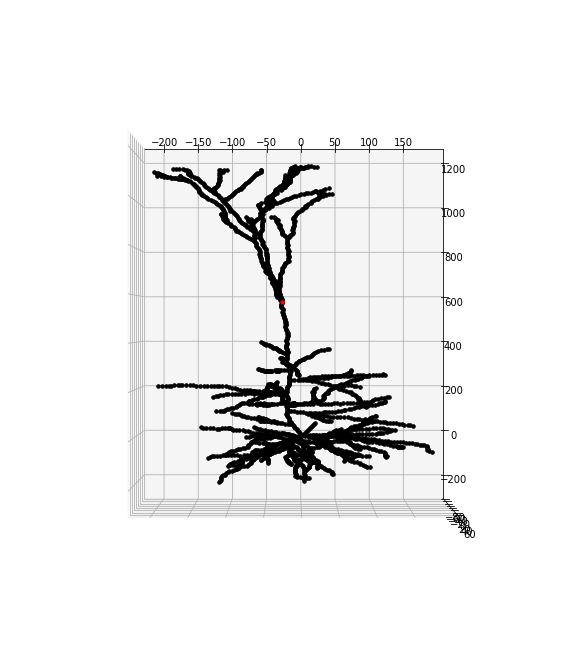

In [21]:
#3D Projection
elev=90 
azim=-90 #20
figsize=(10,12)
# apicsegs=segs[(segs.Type=='apic')]['segmentID']
#create 3d axes
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection='3d')
ax.plot3D(AllSegXCoord, AllSegYCoord,AllSegZCoord,'.',color='k',markersize=7)
# for i in range(len(AllSegXCoord)):
#   ax.scatter(AllSegXCoord[i], AllSegYCoord[i],AllSegZCoord[i],'.',color='k')

print(probes[0].color)
# for i in range(len(probes)):
ax.scatter(xs=AllSegXCoord[probes[firstsegs[-61]].parentprobe[0].seg],
        ys=AllSegYCoord[probes[firstsegs[-61]].parentprobe[0].seg],
        zs=AllSegZCoord[probes[firstsegs[-61]].parentprobe[0].seg],
        marker='*',color=probes[probes[firstsegs[-61]].parentprobe[0].seg].color)
plt.savefig('Probe Locations.png')
# ax.auto_scale_xyz(*box.T)
ax.view_init(elev,azim)
plt.show()

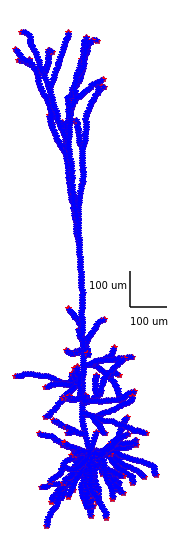

In [22]:
# plt.figure(figsize=(3,10))
# ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
# plt.vlines(110,400,500)
# plt.text(0,450,'100 um')
# plt.hlines(400,110,210)
# plt.text(110,350,'100 um')
# plt.xticks([])
# plt.yticks([])
# plt.box(False)

# for i in range(len(probes)):
#   plt.plot(AllSegXCoord[probes[i].seg],
#          AllSegYCoord[probes[i].seg],
#          '*',color=probes[i].color)
#   for j in range(len(probes[i].adjprobes)):
#       plt.plot(AllSegXCoord[probes[i].adjprobes[j].seg],
#           AllSegYCoord[probes[i].adjprobes[j].seg],
#           '*',color='blue')
# # for i in range(len(probes)):
# #   plt.plot(AllSegXCoord[probes[i].seg],
# #          AllSegYCoord[probes[i].seg],
# #          '*',color=probes[i].color)
# plt.savefig('Probe Locations.png')

Find Nexus Branch Points

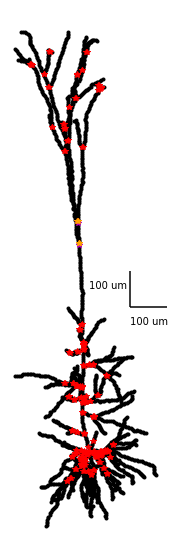

In [35]:
plt.figure(figsize=(3,10))
ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)

for i in firstsegs:
  plt.plot(AllSegXCoord[probes[i].seg],
         AllSegYCoord[probes[i].seg],
         '*',color=probes[i].color)
  # for j in range(len(probes[i].adjprobes)):
  #     plt.plot(AllSegXCoord[probes[i].adjprobes[j].seg],
  #         AllSegYCoord[probes[i].adjprobes[j].seg],
  #         '*',color='blue')

nexus=[probes[firstsegs[-51]].parentprobe[0].seg,probes[firstsegs[-61]].parentprobe[0].seg] #check parentseg()'s by guessing where to index
# adjp=[0] #indexes childprobes of nexus probes to find the adjacent
for i in nexus:
  plt.plot(AllSegXCoord[probes[i].seg],
         AllSegYCoord[probes[i].seg],
         '*',color='m')
  # see all adj probes
  # for j in range(len(probes[].adjprobes)):
  #   plt.plot(AllSegXCoord[probes[].adjprobes[j].seg],
  #       AllSegYCoord[probes[psegs[i]].adjprobes[j].seg],
  #       '*',color='blue')
#see child probes
  for j in range(len(probes[i].childprobes)):
      plt.plot(AllSegXCoord[probes[i].childprobes[j].seg],
          AllSegYCoord[probes[i].childprobes[j].seg],
          '*',color='orange')
#see parent probes      
  # for j in range(len(probes[i].parentprobe)):
  #     plt.plot(AllSegXCoord[probes[i].parentprobe[j].seg],
  #         AllSegYCoord[probes[i].parentprobe[j].seg],
  #         '*',color='blue')

In [60]:
nexus=[probes[firstsegs[-51]].parentprobe[0].seg,probes[firstsegs[-61]].parentprobe[0].seg] #find branch points in nexus
nexusprobes=[] # list of nexus probe objects
for i in nexus: #iterate through nexus segmentIDs
  nexusprobes.append(probes[i]) #get nexus probes
# print(nexusprobes)
for probe in nexusprobes:
  print('nexus branching segment:',probe.seg)
  for i in range(len(probe.childprobes)):
    print('nexus branching segment children segment:',probe.childprobes[i].seg) #child probe segments
    somasegIDs = segs[(segs.Type=='soma')]['segmentID'] #how to pull a column after separating by type

somaprobes=[]
for i in somasegIDs:
  somaprobes.append(probes[i])
print(somaprobes)
print(nexusprobes)

nexus branching segment: 1695
nexus branching segment children segment: 1696
nexus branching segment children segment: 1813
nexus branching segment: 1479
nexus branching segment children segment: 1480
nexus branching segment children segment: 1683
[<__main__.probe object at 0x7fbd299f29d0>, <__main__.probe object at 0x7fbd27c83c50>, <__main__.probe object at 0x7fbd27c83b90>, <__main__.probe object at 0x7fbd27c83c10>, <__main__.probe object at 0x7fbd27c83d10>]
[<__main__.probe object at 0x7fbd279cd110>, <__main__.probe object at 0x7fbd279ecb10>]


In [62]:
def get_probe(probe):
  name=probe.name
  segment=probe.seg
  color=probe.color
  axialcurrents=probe.axialcurrents
  childrenaxialcurrents=probe.childrenaxialcurrents
  parentaxialcurrent=probe.parentaxialcurrent
  adjprobes=probe.adjprobes
  parentprobe=probe.parentprobe
  childprobes=probe.childprobes
  return name,segment,color,axialcurrents,childrenaxialcurrents,parentaxialcurrent,adjprobes,parentprobe,childprobes

def plot_axial_current(probe):
  name,segment,color,axialcurrents,childrenaxialcurrents,parentaxialcurrent,adjprobes,parentprobe,childprobes=get_probe(probe)
  title=name+' Axial Current'
  plt.figure(figsize=(12.8, 4.8))
  # for i,AC in enumerate(axial_current):
  for c in range(len(parentaxialcurrent)):
      # plt.plot(t,ac[dend_type].ravel(),label=dend_type)
      plt.plot(t,parentaxialcurrent[c],label=parentprobe[c].name,color='purple')
  for c in range(len(childrenaxialcurrents)):
      plt.plot(t,childrenaxialcurrents[c],label=childprobes[c].name,color='cyan')
  plt.ylabel('nA')
  plt.legend()
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.show()

def plot_sum_child_axial_current(probe):
  name,segment,color,axialcurrents,childrenaxialcurrents,parentaxialcurrent,adjprobes,parentprobe,childprobes=get_probe(probe)
  title=name+' Axial Current'
  plt.figure(figsize=(12.8, 4.8))
  # for i,AC in enumerate(axial_current):
  # for c in range(len(parentaxialcurrent)):
  #     # plt.plot(t,ac[dend_type].ravel(),label=dend_type)
  #     plt.plot(t,parentaxialcurrent[c],label=parentprobe[c].name,color='purple')
  axc=np.zeros(len(childrenaxialcurrents[0]))
  for c in range(len(childrenaxialcurrents)):
    axc+=childrenaxialcurrents[c] #sum the children axial currents
  for c in range(len(childrenaxialcurrents)):
      plt.plot(t,axc,label=childprobes[c].name,color='cyan')
  plt.ylabel('nA')
  plt.legend()
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.show()

def sumcurrents(currents):
  current=np.zeros(len(currents[0]))
  for i in range(len(currents)):
    current+=currents[i]
  return current

def sumcurrentsfromprobes(probes):
  probesaxc=np.zeros(len(probes[0].axialcurrents[0]))
  for i in range(len(probes)):
    axc=sumcurrents(probes[i].axialcurrents)
    probesaxc+=axc
  return probesaxc
  

def getsummedprobenames(probe,arg):
  name=''
  if arg == 'adjprobes':
    for i in range(len(probe.adjprobes)):
      name+=(' '+probe.adjprobes[i].name)
    print(name)
  elif arg == 'childprobes':
    for i in range(len(probe.childprobes)):
      name+=(' '+probe.childprobes[i].name)
    print(name)
  elif arg == 'parentprobe':
    for i in range(len(probe.parentprobe)):
      name+=(' '+probe.parentprobe[i].name)
  return name


def plot_net_axial_current(probe,title=None):
  name,segment,color,axialcurrents,childrenaxialcurrents,parentaxialcurrent,adjprobes,parentprobe,childprobes=get_probe(probe)
  if title==None:
    title=name+' Net Axial Current'
  else:
    title=title+' Net Axial Current'
  plt.figure(figsize=(12.8, 4.8))
  # for i,AC in enumerate(axial_current):
  # for c in range(len(parentaxialcurrent)):
  #     # plt.plot(t,ac[dend_type].ravel(),label=dend_type)
  #     plt.plot(t,parentaxialcurrent[c],label=parentprobe[c].name,color='purple')
  axc=sumcurrents(axialcurrents)
  label=getsummedprobenames(probe,'adjprobes')
  plt.plot(t,axc,label=label,color='red')

  plt.ylabel('nA')
  plt.legend()
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.show()

def plot_net_axial_currentmultiprobe(probes,title=None):
  # name,segment,color,axialcurrents,childrenaxialcurrents,parentaxialcurrent,adjprobes,parentprobe,childprobes=get_probe(probe)
  if title==None:
    title=name+' Net Axial Current'
  else:
    title=title+' Net Axial Current'
  plt.figure(figsize=(12.8, 4.8))
  # for i,AC in enumerate(axial_current):
  # for c in range(len(parentaxialcurrent)):
  #     # plt.plot(t,ac[dend_type].ravel(),label=dend_type)
  #     plt.plot(t,parentaxialcurrent[c],label=parentprobe[c].name,color='purple')
  axc=sumcurrentsfromprobes(probes)
  label=''
  # for i in range(len(probes)):
  #   label+=getsummedprobenames(probes[i],'adjprobes')
  plt.plot(t,axc,label=label,color='red')

  plt.ylabel('nA')
  plt.legend()
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.show()

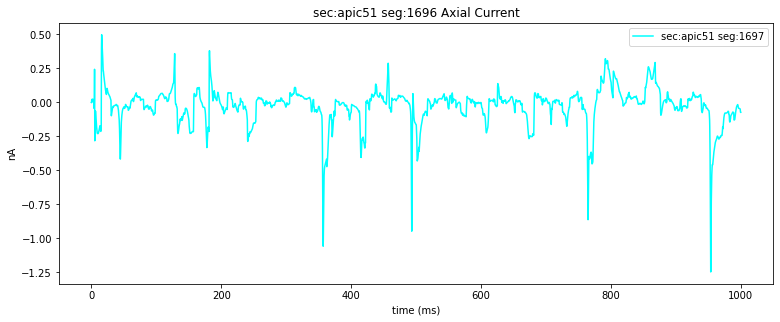

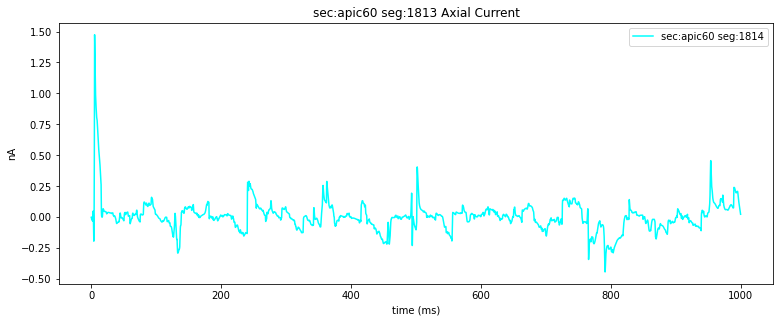

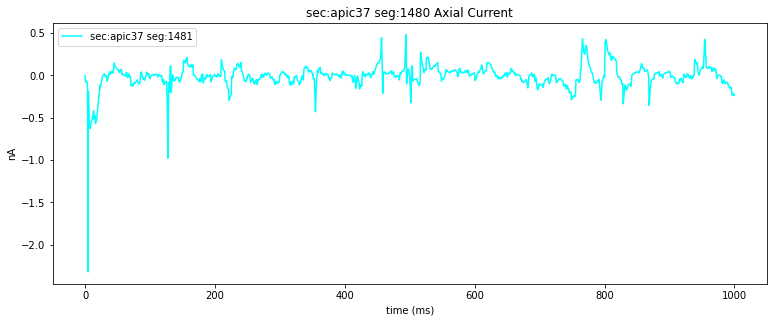

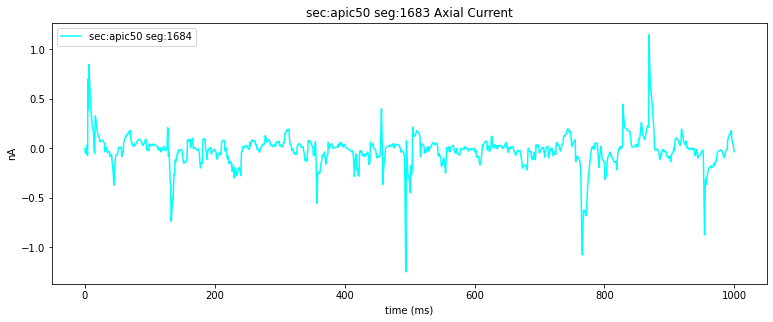

In [65]:
for probe in nexusprobes: #nexus probes are at the branching points of nexus
  for childprobe in probe.childprobes: #there will be one child probe per unique branching path
    plot_sum_child_axial_current(childprobe) #plot the axial current going down each dendrite

 sec:apic37 seg:1480 sec:apic50 seg:1683 sec:apic36 seg:1478


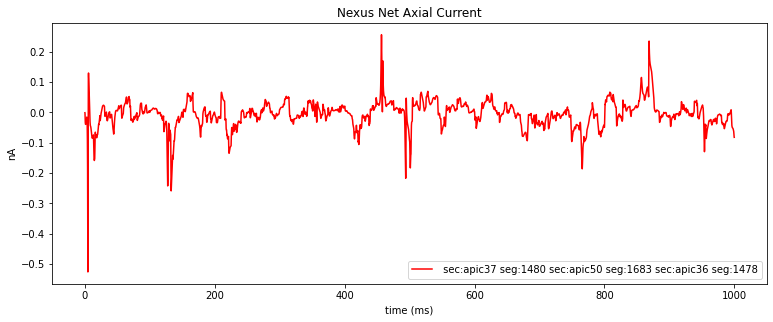

In [33]:
for probe in nexus:
  plot_net_axial_current(probe, 'Nexus')

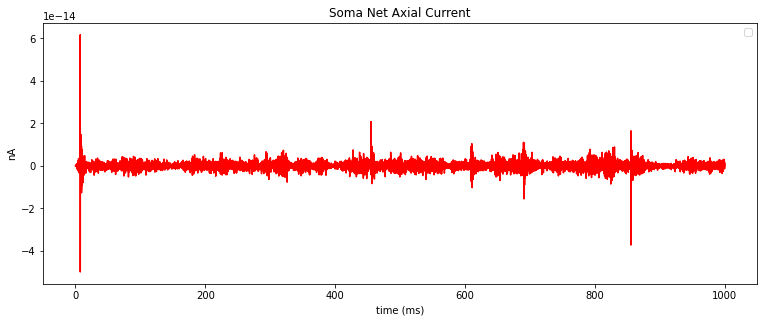

In [34]:
for probe in [soma]:
  plot_net_axial_currentmultiprobe(probes, 'Soma')